<a href="https://colab.research.google.com/github/oz-e/applied-ml/blob/main/cosine_similarity_CuPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAILSWRMXLiLiXUluNy/VILqW3MqLh7uahmM/HZAxWMXXF root@138ced0b481d

Please use SSH method to clone repo.
/content
Cloning into 'applied-ml'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 165 (delta 7), reused 0 (delta 0), pack-reused 144 (from 1)
Receiving objects: 100% (165/165), 6.13 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/applied-ml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=3f9

In [3]:
import os

if not os.path.exists("CuPL"):
    !git clone https://github.com/sarahpratt/CuPL.git

Cloning into 'CuPL'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 56 (delta 6), reused 52 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 4.68 MiB | 16.87 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
import matplotlib.pyplot as plt

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)

100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 85.0MiB/s]


In [7]:
import aml.datasets

all_images = aml.datasets.Flowers102(datasets_path, split='test')

100%|██████████| 345M/345M [00:19<00:00, 18.1MB/s]
100%|██████████| 502/502 [00:00<00:00, 398kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 26.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pp0sRXzZFZq15zVOzKjKBu4A9i01nozT
To: /content/applied-ml/datasets/flowers-102/split.json
100%|██████████| 771k/771k [00:00<00:00, 134MB/s]


In [8]:
from collections import defaultdict

grouped_images = defaultdict(list)
for image, label in all_images:
    grouped_images[label].append(image)

In [9]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/flower_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts = json.load(f)

In [10]:
special_class_mapping = {
    'globe flower': 'globe-flower',
    'pink and yellow dahlia': 'pink-yellow dahlia',
    'air plant': 'ball moss',
}

In [11]:
# For bridging classsname in dataset with name in CuLP prompts
new_gpt3_prompts = {}

for key, value in gpt3_prompts.items():
    new_key = special_class_mapping.get(key, key)
    new_gpt3_prompts[new_key.lower()] = value

In [34]:
def calc_similarity(org_imgs, texts_list):
    with torch.no_grad():
        img_inputs = torch.stack([preprocess(org_img) for org_img in org_imgs])
        img_features = model.encode_image(img_inputs.to(device))
        img_features /= img_features.norm(dim=-1, keepdim=True)

        text_features = []
        for texts in texts_list:
            class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            text_features.append(class_embedding)
        text_features = torch.stack(text_features)

        similarity = text_features @ img_features.T
        similarity = similarity.cpu().numpy()

    return similarity

In [13]:
def plot_similarity(cls_names, org_imgs, texts_list):
    similarity = calc_similarity(org_imgs, texts_list)

    count = len(cls_names)

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    # plt.colorbar()
    plt.yticks(range(count), cls_names, fontsize=18)
    plt.xticks([])
    for i, img in enumerate(org_imgs):
        plt.imshow(img, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title("Cosine similarity between text and image features", size=20)

In [29]:
n_cls = 10

cls_names = [all_images.lab2cname[i] for i in range(n_cls)]
org_imgs = [grouped_images[i][0] for i in range(n_cls)]

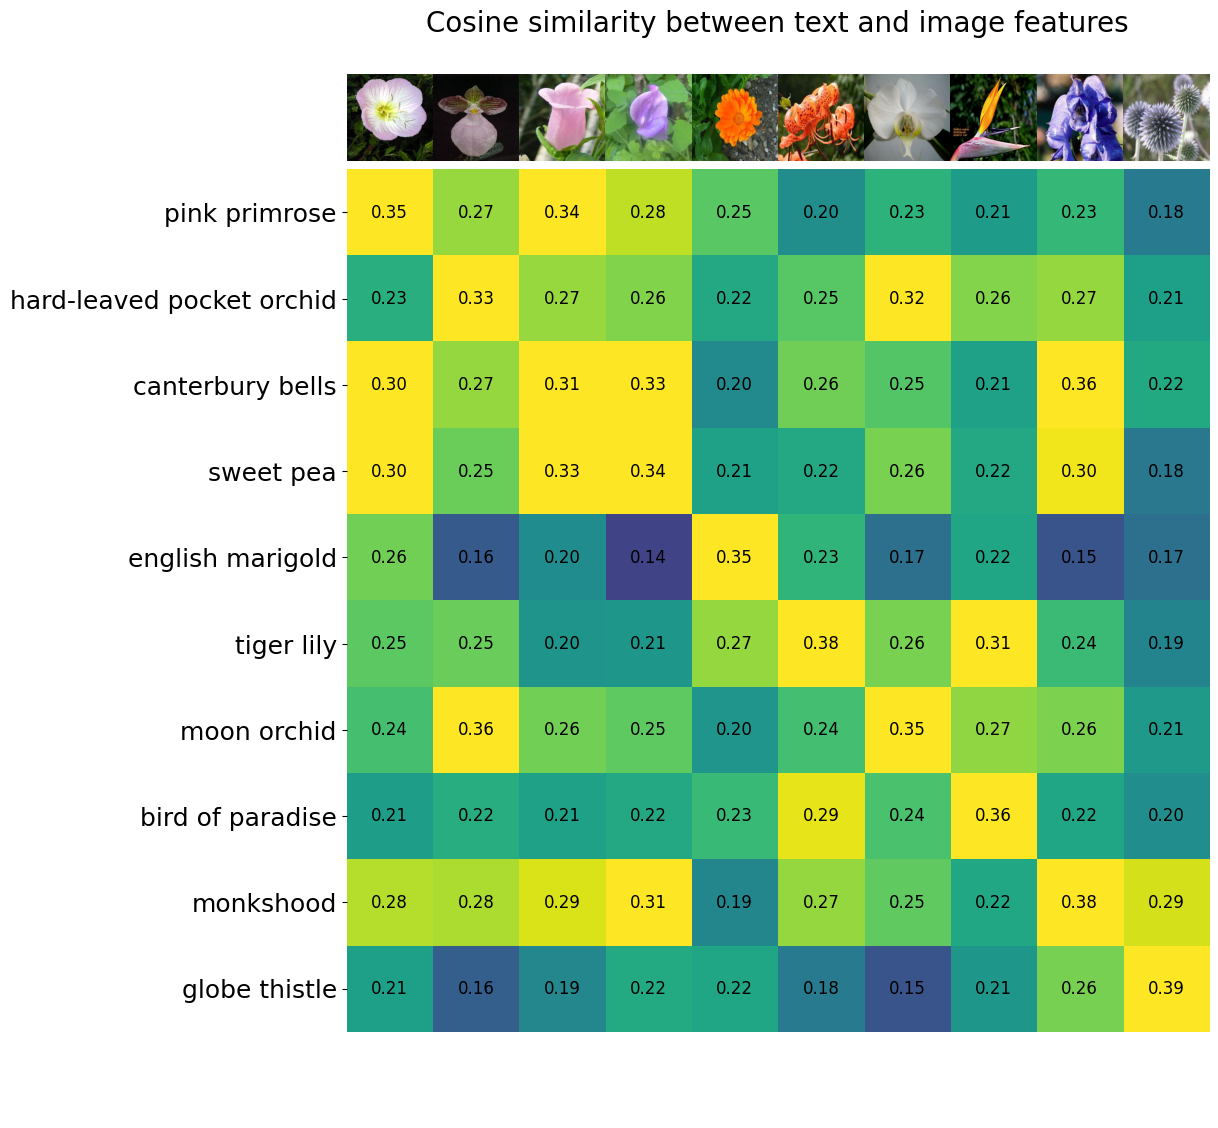

In [35]:
texts_list = [new_gpt3_prompts[cls_name] for cls_name in cls_names]
plot_similarity(cls_names, org_imgs, texts_list)

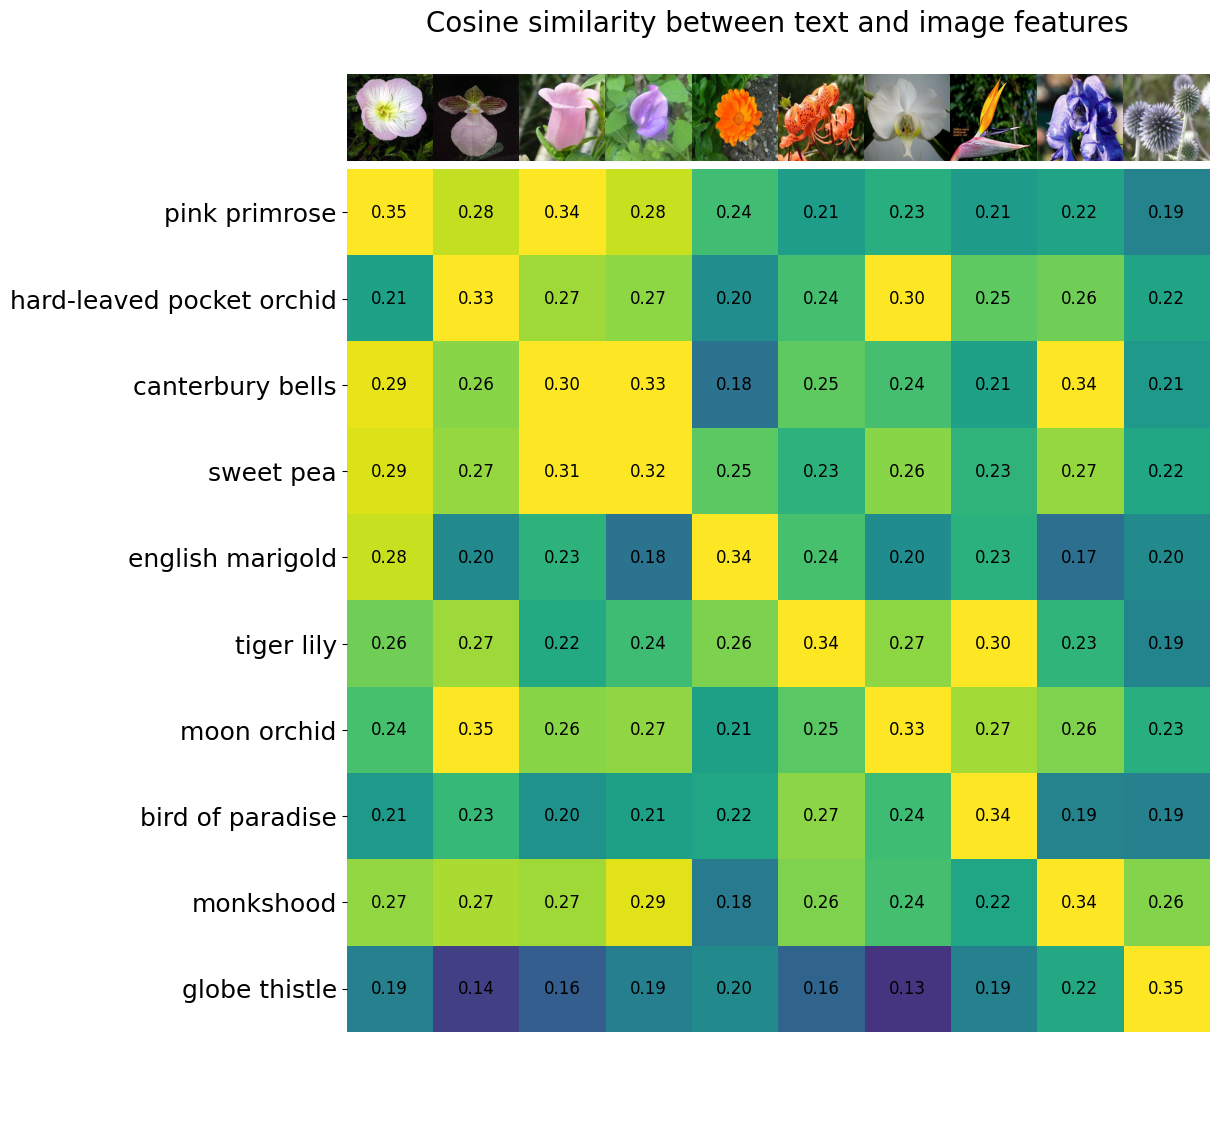

In [31]:
texts_list = [[template.format(cls_name) for template in imagenet_templates] for cls_name in cls_names]
plot_similarity(cls_names, org_imgs, texts_list)